# Healthy and Bleached Corals Image Classification

In [1]:
!pip install transformers torch

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from transformers import AutoImageProcessor, AutoModelForImageClassification
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Define your custom Dataset class
class CoralDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

In [4]:
# Assuming you have your image dataset organized into two folders: 'healthy' and 'bleached'
HEALTHY_IMAGES_DIR = "/data/healthy_corals"
healthy_image_paths = [os.path.join(HEALTHY_IMAGES_DIR, img) for img in os.listdir(HEALTHY_IMAGES_DIR) if os.path.isfile(os.path.join(HEALTHY_IMAGES_DIR, img))]
BLEACHED_IMAGES_DIR = "/data/bleached_corals"
bleached_image_paths = [os.path.join(BLEACHED_IMAGES_DIR, img) for img in os.listdir(BLEACHED_IMAGES_DIR) if os.path.isfile(os.path.join(BLEACHED_IMAGES_DIR, img))]

image_paths = healthy_image_paths + bleached_image_paths
labels = [0] * len(healthy_image_paths) + [1] * len(bleached_image_paths)

# Split the data into train and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

In [8]:
# Calculate mean and standard deviation for normalization
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Temporary dataset to calculate mean and std
train_dataset_for_stats = CoralDataset(train_paths, train_labels, transform=train_transform)
train_loader_for_stats = DataLoader(train_dataset_for_stats, batch_size=40, shuffle=False, num_workers=0)

mean = 0.
std = 0.
nb_samples = 0.

for data in train_loader_for_stats:
    images, _ = data
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(f"Calculated Mean: {mean}")
print(f"Calculated Std: {std}")

Calculated Mean: tensor([0.3119, 0.4154, 0.4176])
Calculated Std: tensor([0.1932, 0.1951, 0.2077])


In [12]:
# Image transformations using calculated mean and std
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

# Create train and validation datasets
train_dataset = CoralDataset(train_paths, train_labels, transform=transform)
val_dataset = CoralDataset(val_paths, val_labels, transform=transform)

# DataLoader for train and validation sets
train_loader = DataLoader(train_dataset, batch_size=40, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=40, shuffle=False, num_workers=0)

# Load the pretrained MobileNet model
model = AutoModelForImageClassification.from_pretrained("google/mobilenet_v2_1.0_224")

# Replace the classifier layer to output a single value for binary classification
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, 1),
    nn.Sigmoid()
)

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set up the optimizer and loss function
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
epochs = 10
training_results = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images).logits.squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits.squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {val_accuracy:.2f}%")
    
    # Store training results for correlation matrix
    training_results.append({'epoch': epoch + 1, 'train_loss': running_loss / len(train_loader), 'val_loss': val_loss / len(val_loader), 'val_accuracy': val_accuracy})

print("Training complete.")

# Save the fine-tuned model
model.save_pretrained("path/to/save/finetuned_model")

Epoch [1/10], Loss: 0.6068, Val Loss: 0.5254, Val Accuracy: 75.14%
Epoch [2/10], Loss: 0.3552, Val Loss: 0.5220, Val Accuracy: 75.68%
Epoch [3/10], Loss: 0.2202, Val Loss: 0.5058, Val Accuracy: 72.43%
Epoch [4/10], Loss: 0.1129, Val Loss: 0.5335, Val Accuracy: 74.05%
Epoch [5/10], Loss: 0.0698, Val Loss: 0.6139, Val Accuracy: 80.54%
Epoch [6/10], Loss: 0.0442, Val Loss: 0.6459, Val Accuracy: 74.59%
Epoch [7/10], Loss: 0.0321, Val Loss: 0.9028, Val Accuracy: 67.03%
Epoch [8/10], Loss: 0.0242, Val Loss: 0.7473, Val Accuracy: 77.30%
Epoch [9/10], Loss: 0.0229, Val Loss: 0.8730, Val Accuracy: 68.65%
Epoch [10/10], Loss: 0.0206, Val Loss: 0.7456, Val Accuracy: 75.68%
Training complete.


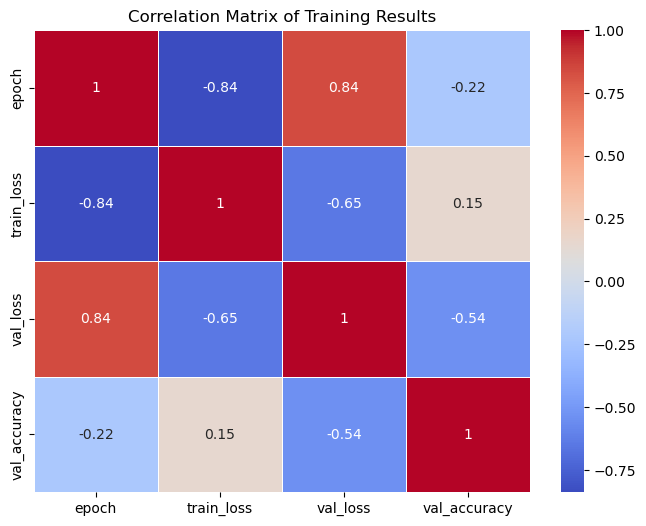

In [19]:
# Display correlation matrix for training results
results_df = pd.DataFrame(training_results)
corr_matrix = results_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix of Training Results")
plt.show()